For the below code:
Obstacles are colored gray, the pick-up location is green, the drop-off location is red, the robot is blue, and the robot carrying the object is yellow.

Initial Warehouse Environment:


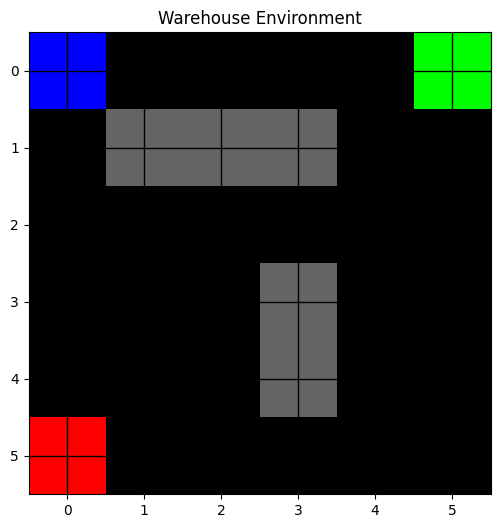

Step 1:
Action: 1, Reward: -1, New State: (0, 1), Has Object: False


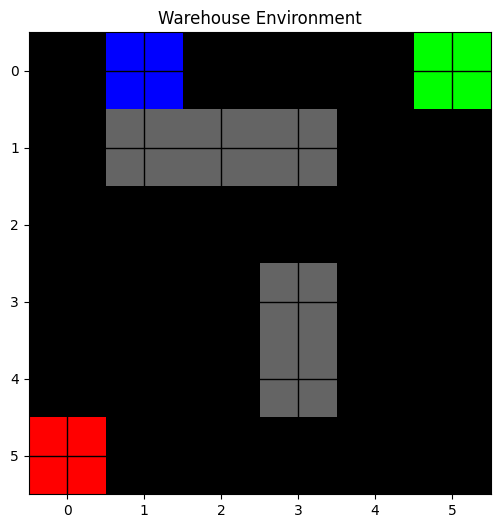

Step 2:
Action: 4, Reward: -1, New State: (0, 1), Has Object: False


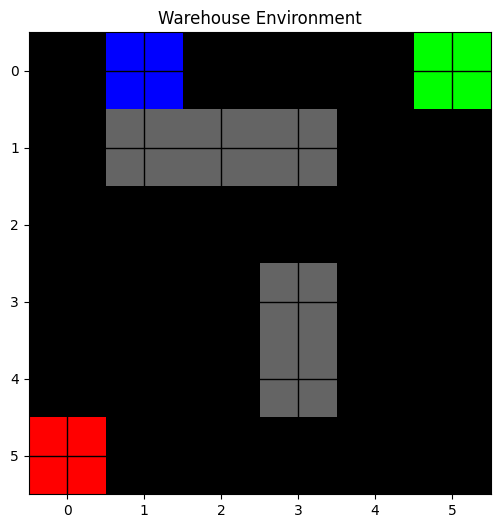

Step 3:
Action: 3, Reward: -1, New State: (0, 0), Has Object: False


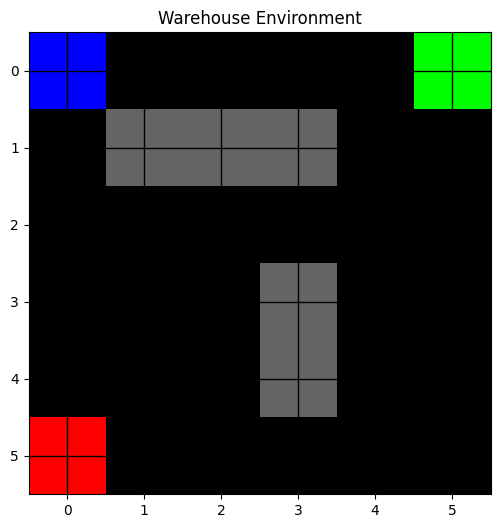

Step 4:
Action: 3, Reward: -1, New State: (0, 0), Has Object: False


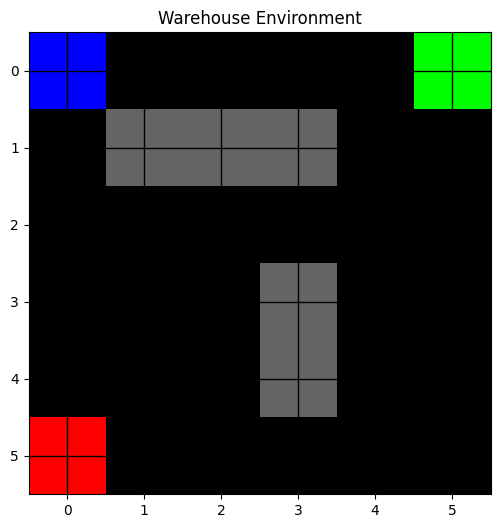

Step 5:
Action: 1, Reward: -1, New State: (0, 1), Has Object: False


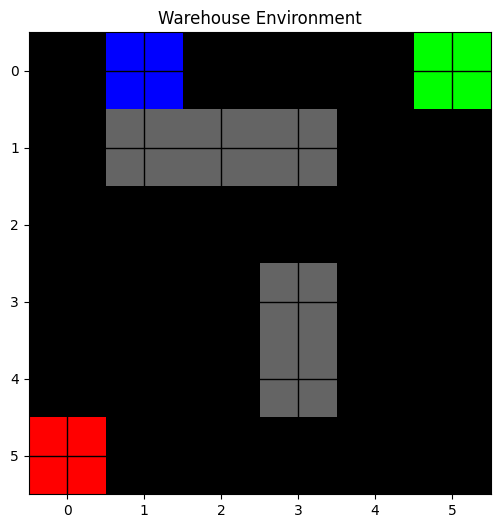

Step 6:
Action: 1, Reward: -1, New State: (0, 2), Has Object: False


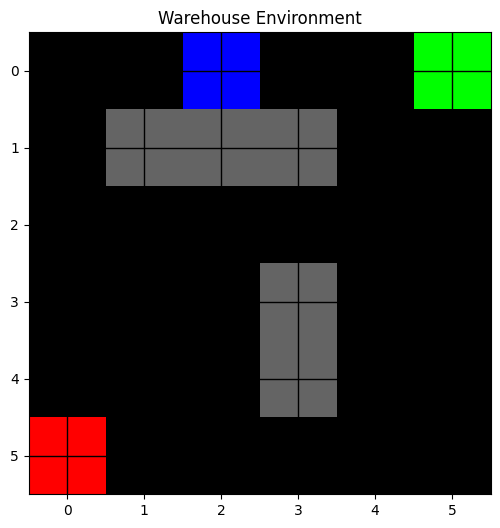

Step 7:
Action: 2, Reward: -20, New State: (1, 2), Has Object: False


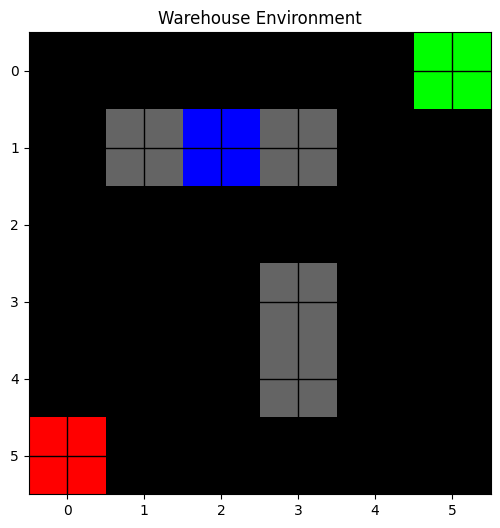

Step 8:
Action: 0, Reward: -1, New State: (0, 2), Has Object: False


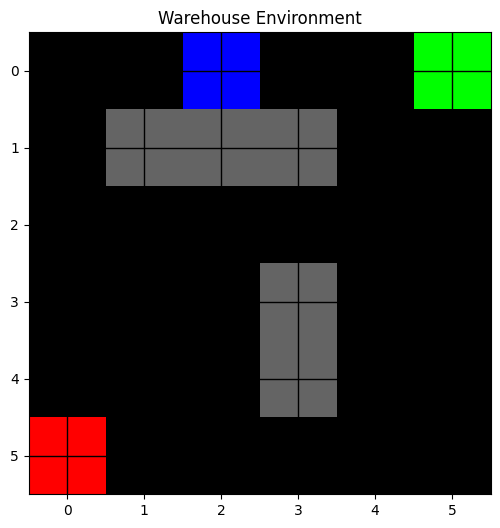

Step 9:
Action: 4, Reward: -1, New State: (0, 2), Has Object: False


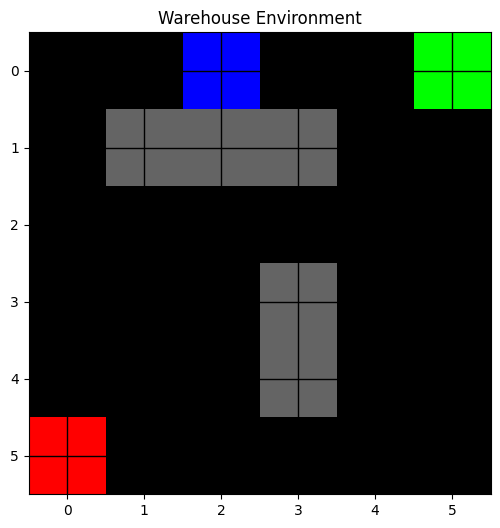

Step 10:
Action: 0, Reward: -1, New State: (0, 2), Has Object: False


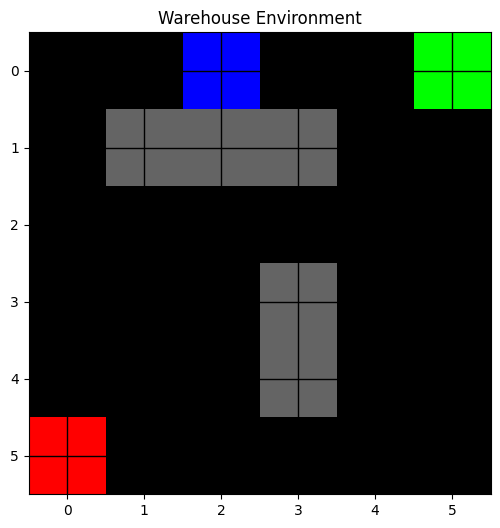

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random
from gym import Env
from gym.spaces import Discrete, Tuple

class WarehouseEnv(Env):
    def __init__(self):
        self.grid_size = 6
        self.action_space = Discrete(6)  # 0=Up, 1=Right, 2=Down, 3=Left, 4=Pick-up, 5=Drop-off
        self.observation_space = Tuple([Discrete(self.grid_size), Discrete(self.grid_size), Discrete(2)])  # (x, y, has_object)

        self.obstacles = [(1, 1), (1, 2), (1, 3), (3, 3), (4, 3)]
        self.pick_up_location = (0, 5)
        self.drop_off_location = (5, 0)

        self.reward_step = -1
        self.reward_hit_obstacle = -20
        self.reward_pick_up = 25
        self.reward_delivery = 100

        self.state = None
        self.has_object = False

    def reset(self):
        self.state = (0, 0)
        self.has_object = False
        return (self.state, self.has_object)

    def step(self, action):
        row, col = self.state

        # Handle movement actions
        if action == 0 and row > 0:         # Up
            row -= 1
        elif action == 1 and col < self.grid_size - 1:  # Right
            col += 1
        elif action == 2 and row < self.grid_size - 1:  # Down
            row += 1
        elif action == 3 and col > 0:       # Left
            col -= 1

        # Handle pick-up and drop-off actions
        if action == 4 and not self.has_object and (row, col) == self.pick_up_location:
            self.has_object = True
            reward = self.reward_pick_up
        elif action == 5 and self.has_object and (row, col) == self.drop_off_location:
            self.has_object = False
            reward = self.reward_delivery
            done = True
            self.state = (row, col)
            return (self.state, self.has_object), reward, done, {}

        else:
            reward = self.reward_step

        # Handle obstacle collision
        if (row, col) in self.obstacles:
            reward = self.reward_hit_obstacle
            done = False
        else:
            done = False

        self.state = (row, col)

        # Check if robot has delivered the item
        if not self.has_object and self.state == self.drop_off_location:
            done = True

        return (self.state, self.has_object), reward, done, {}

    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size, 3), dtype=int)  # Create a grid with RGB colors
        for (r, c) in self.obstacles:
            grid[r, c] = [100, 100, 100]  # Gray for obstacles
        grid[self.pick_up_location] = [0, 255, 0]  # Green for pick-up location
        grid[self.drop_off_location] = [255, 0, 0]  # Red for drop-off location
        r, c = self.state
        grid[r, c] = [0, 0, 255] if not self.has_object else [255, 255, 0]  # Blue for robot, Yellow if carrying object

        plt.figure(figsize=(6, 6))
        plt.imshow(grid, interpolation='nearest')
        plt.xticks(range(self.grid_size))
        plt.yticks(range(self.grid_size))
        plt.grid(color='black', linestyle='-', linewidth=1)
        plt.title("Warehouse Environment")
        plt.show()

# Create and test the environment
env = WarehouseEnv()
state, has_object = env.reset()

print("Initial Warehouse Environment:")
env.render()

# Simulate random steps and visualize
for step in range(10):
    print(f"Step {step + 1}:")
    action = env.action_space.sample()
    (state, has_object), reward, done, _ = env.step(action)
    print(f"Action: {action}, Reward: {reward}, New State: {state}, Has Object: {has_object}")
    env.render()
    if done:
        print("Task completed!")
        break


Sarsa Implementation

In [5]:
class SARSA_Agent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = self.init_q_table()

    def init_q_table(self):
        return np.zeros((self.env.grid_size, self.env.grid_size, 2, self.env.action_space.n))  # 2 for holding object or not

    def choose_action(self, state, has_object):
        if random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        row, col = state
        return np.argmax(self.q_table[row, col, int(has_object)])

    def train(self, num_episodes=500, max_timesteps=100):
        rewards_per_episode = []
        epsilon_values = []
        initial_q_table = np.copy(self.q_table)
        for episode in range(num_episodes):
            state, has_object = self.env.reset()
            action = self.choose_action(state, has_object)
            total_reward = 0
            for _ in range(max_timesteps):
                (next_state, next_has_object), reward, done, _ = self.env.step(action)
                next_action = self.choose_action(next_state, next_has_object)
                row, col = state
                next_row, next_col = next_state
                self.q_table[row, col, int(has_object), action] += self.alpha * (
                    reward + self.gamma * self.q_table[next_row, next_col, int(next_has_object), next_action] -
                    self.q_table[row, col, int(has_object), action]
                )
                state, has_object = next_state, next_has_object
                action = next_action
                total_reward += reward
                if done:
                    break
            rewards_per_episode.append(total_reward)
            epsilon_values.append(self.epsilon)
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
        return rewards_per_episode, epsilon_values, initial_q_table

    def evaluate_greedy_policy(self, num_episodes=10, max_timesteps=100):
        rewards_per_episode = []
        for _ in range(num_episodes):
            state, has_object = self.env.reset()
            total_reward = 0
            for _ in range(max_timesteps):
                row, col = state
                action = np.argmax(self.q_table[row, col, int(has_object)])
                (state, has_object), reward, done, _ = self.env.step(action)
                total_reward += reward
                if done:
                    break
            rewards_per_episode.append(total_reward)
        return rewards_per_episode

Initial Q-table:
[[[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0

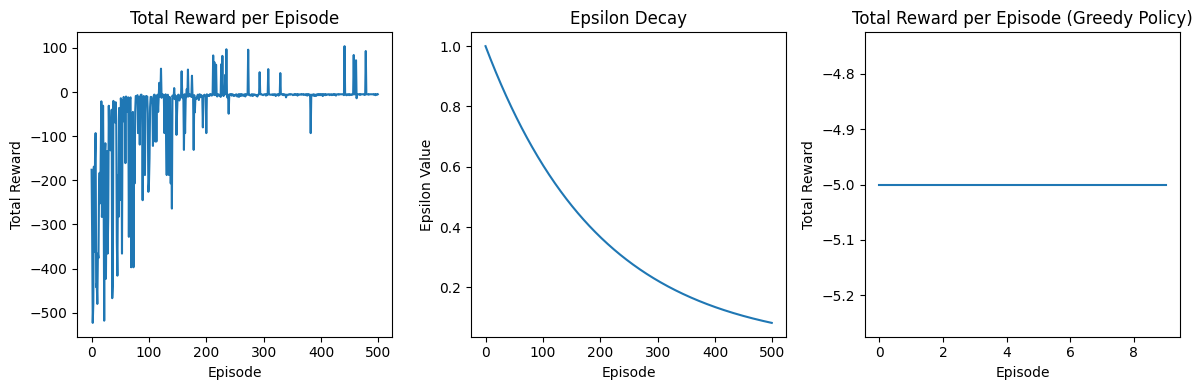

In [6]:
env = WarehouseEnv()
agent = SARSA_Agent(env)

# Train the agent
num_episodes = 500
rewards, epsilons, initial_q_table = agent.train(num_episodes=num_episodes)

# Evaluate the greedy policy
greedy_rewards = agent.evaluate_greedy_policy()

# Print results
print("Initial Q-table:")
print(initial_q_table)
print("\nTrained Q-table:")
print(agent.q_table)

# Plotting graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(rewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(1, 3, 2)
plt.plot(epsilons)
plt.title('Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')

plt.subplot(1, 3, 3)
plt.plot(greedy_rewards)
plt.title('Total Reward per Episode (Greedy Policy)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.tight_layout()
plt.show()